<a href="https://colab.research.google.com/github/ananyakundu23/Suicide-Detection/blob/main/Full_preprocessing_%7C_Tuned_CNN%2C_GRU%2C_LSTM_93_Acc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'suicide-watch:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1075326%2F2250642%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241005%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241005T105748Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D53505c097725c3c3d18fb7d0c8801dd675aa14458bdfecbe384758034d1503d2ff977bf395fa5647ff65181dcc8ad9a8195280cf3f1a88b9d84066efefc59da77d749db0d0c9be86b938424fbe37e9ab05f6cbd9f5bb3fed0171c632d7b640f3c15b363a670e9c98fce5c1d61a8938e6d48eca05032fe59d68ecc8b4ba02089a94dc83c309b242d38a7c93906fdd67eebc764f44d4618b347b7c33c243e382a16acf616c643e5bb0a6d80f28d60e101530722305775121483d2e3e2ccdcf19c17c93908840f3775d3eb7a9e8e0ce16a639ededa687e5e9568cd3690397165f5e9d54e55cb065bd52a03c90a4a6e08f7eb9136266c63166badb23195dc9498197'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 63553670 bytes downloaded
Downloaded and uncompressed: suicide-watch
Data source import complete.


In [3]:
!pip install langdetect


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 13.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993221 sha256=72b90f951303b41429cb071b448e668d4be6a503da95ab2ca22cd0570d42f9e1
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


# Import Libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import nltk
import re
import string
import wordcloud
from langdetect import detect
from collections import Counter
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import words

# Load & Read Dataset

In [11]:
import pandas as pd

# The uploaded file will have the same name as on your system.
df = pd.read_csv('Suicide_Detection.csv')

# Check the first few rows of the dataframe
df.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


# EDA

## Check top observations

In [12]:
df.head(10)

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide
5,11,Honetly idkI dont know what im even doing here...,suicide
6,12,[Trigger warning] Excuse for self inflicted bu...,suicide
7,13,It ends tonight.I can’t do it anymore. \nI quit.,suicide
8,16,"Everyone wants to be ""edgy"" and it's making me...",non-suicide
9,18,My life is over at 20 years oldHello all. I am...,suicide


## Check Dimension, No.of Row & Column

In [13]:
# Check the dimensions of the data
print("Dimension: ",df.shape)

# Number of rows and columns
print("Number of rows in data =",df.shape[0])
print("Number of columns in data =",df.shape[1])

# Print the column names
column_names = df.columns
print(column_names)

Dimension:  (232074, 3)
Number of rows in data = 232074
Number of columns in data = 3
Index(['Unnamed: 0', 'text', 'class'], dtype='object')


## Check Summary

In [14]:
df['Unnamed: 0'].is_unique

True

In [15]:
df = df.drop(columns=['Unnamed: 0'])
df.describe()

,text,class
count,232074,232074
unique,232074,2
top,Ex Wife Threatening SuicideRecently I left my ...,suicide
freq,1,116037


## Check Missing Value

In [16]:
print("Check for missing values in the dataset")
null_check=df.isnull().sum()
print(null_check)

Check for missing values in the dataset
text     0
class    0
dtype: int64


## Check Duplicates

In [17]:
# Check for duplicate rows in the entire DataFrame
duplicate_rows = df.duplicated()

# Count the number of duplicate rows
num_duplicates = duplicate_rows.sum()

# Display the duplicate rows
duplicate_data = df[duplicate_rows]

print(f"Number of duplicate rows: {num_duplicates}")
print("Duplicate rows:")
print(duplicate_data)

Number of duplicate rows: 0
Duplicate rows:
Empty DataFrame
Columns: [text, class]
Index: []


## Distribution of Class

In [18]:
df['class'].value_counts()

,count
class,
suicide,116037
non-suicide,116037


<Axes: xlabel='class', ylabel='Count'>

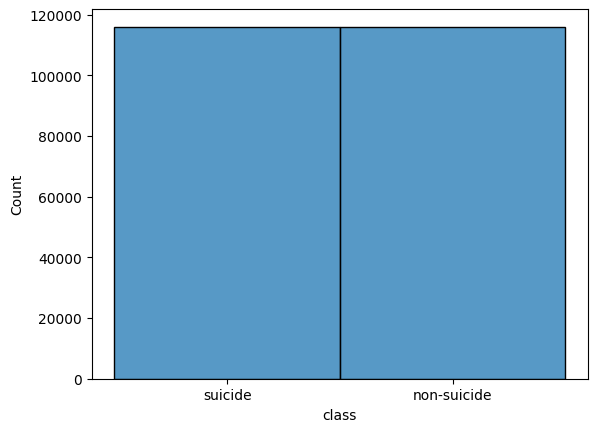

In [19]:
sns.histplot(df['class'],binwidth=0.5)

## Word Cloud

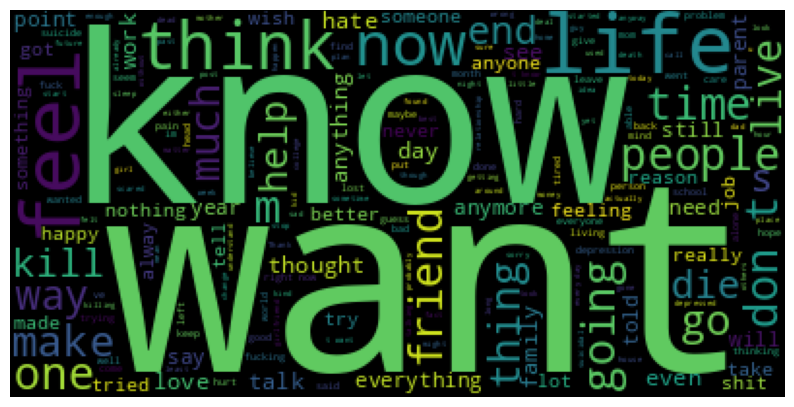

In [20]:
suicide=df[df['class']=='suicide']['text']
xsuicide=df[df['class']=='non-suicide']['text']

def display_cloud(data):
    plt.subplots(figsize=(10,10))
    wc = wordcloud.WordCloud(
                   background_color="black",
                   colormap='viridis',
                   max_words=1000,
                   random_state=24)
    plt.imshow(wc.generate(' '.join(data)))
    plt.axis('off')
    plt.show()

display_cloud(suicide)

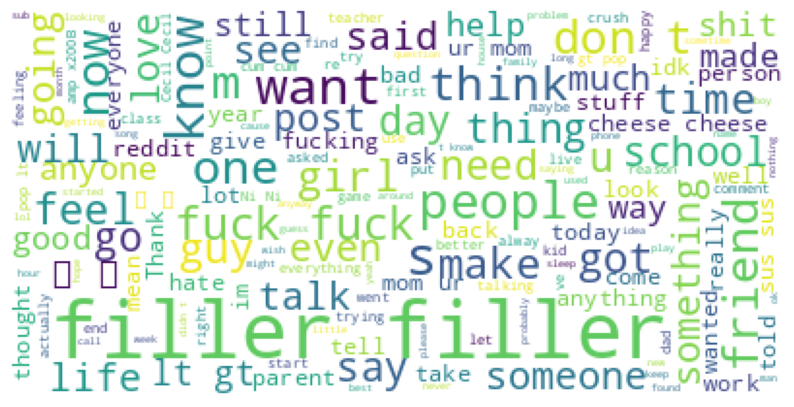

In [21]:
def display_cloud1(data):
    plt.subplots(figsize=(10,10))
    wc = wordcloud.WordCloud(
                   background_color="white",
                   max_words=1000,
                   random_state=24)
    plt.imshow(wc.generate(' '.join(data)))
    plt.axis('off')
    plt.show()

display_cloud1(xsuicide)

## Length of Text

<ipython-input-22-f516e1642e67>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(count_suicide, ax=ax1, color='Orange')
<ipython-input-22-f516e1642e67>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(count_xsuicide, ax=ax2, color='Green')


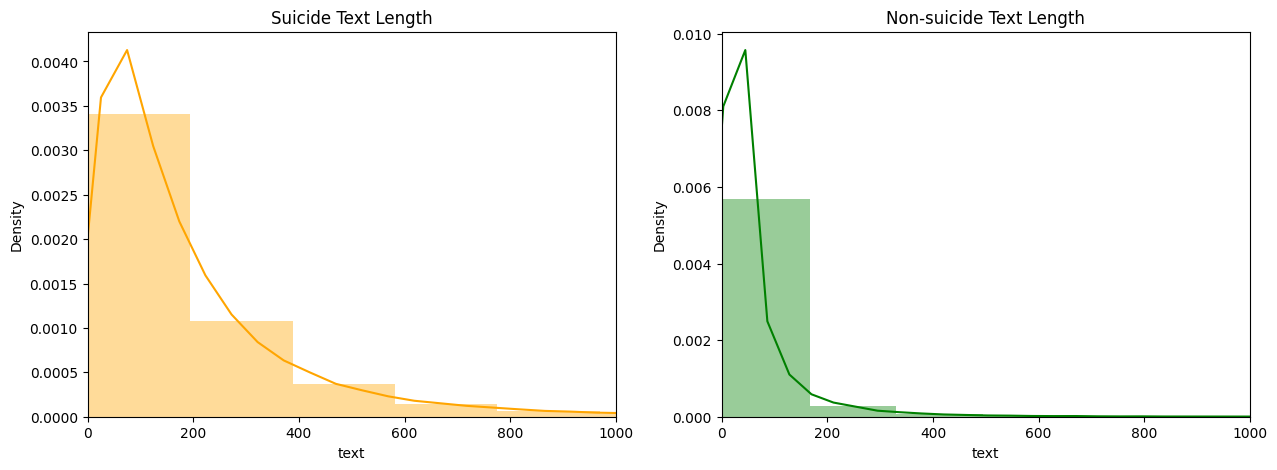

In [22]:
#Analyse the count of words in each segment- both positive and negative reviews
# Function for checking word length
def cal_len(data):
    return len(data)

# Create generic plotter with Seaborn
def plot_count(count_suicide, count_xsuicide, xlim_range=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    sns.distplot(count_suicide, ax=ax1, color='Orange')
    ax1.set_title("Suicide Text Length")

    sns.distplot(count_xsuicide, ax=ax2, color='Green')
    ax2.set_title("Non-suicide Text Length")

    # Set x-axis range if specified
    if xlim_range:
        ax1.set_xlim(xlim_range)
        ax2.set_xlim(xlim_range)

    plt.show()

# Assuming you want to set the x-axis range from 0 to 1000
xlim_range = (0, 1000)

count_suicide_words = suicide.str.split().apply(lambda z: cal_len(z))
count_xsuicide_words = xsuicide.str.split().apply(lambda z: cal_len(z))

plot_count(count_suicide_words, count_xsuicide_words, xlim_range)

# Data Preprocessing

## Lowercasing

In [23]:
# Lowercasing
df['text'] = df['text'].str.lower()

In [24]:
df.head(10)

,text,class
0,ex wife threatening suiciderecently i left my ...,suicide
1,am i weird i don't get affected by compliments...,non-suicide
2,finally 2020 is almost over... so i can never ...,non-suicide
3,i need helpjust help me im crying so hard,suicide
4,"i’m so losthello, my name is adam (16) and i’v...",suicide
5,honetly idki dont know what im even doing here...,suicide
6,[trigger warning] excuse for self inflicted bu...,suicide
7,it ends tonight.i can’t do it anymore. \ni quit.,suicide
8,"everyone wants to be ""edgy"" and it's making me...",non-suicide
9,my life is over at 20 years oldhello all. i am...,suicide


## Normalizing '

In [25]:
df['text'] = df['text'].str.replace("’", "'")

In [26]:
df.head(10)

,text,class
0,ex wife threatening suiciderecently i left my ...,suicide
1,am i weird i don't get affected by compliments...,non-suicide
2,finally 2020 is almost over... so i can never ...,non-suicide
3,i need helpjust help me im crying so hard,suicide
4,"i'm so losthello, my name is adam (16) and i'v...",suicide
5,honetly idki dont know what im even doing here...,suicide
6,[trigger warning] excuse for self inflicted bu...,suicide
7,it ends tonight.i can't do it anymore. \ni quit.,suicide
8,"everyone wants to be ""edgy"" and it's making me...",non-suicide
9,my life is over at 20 years oldhello all. i am...,suicide


## Replace Abbreviations

In [27]:
abb = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "dont": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "idk": "i do not know",
  "he'd've": "he would have",
  "he'll": "he will",  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "i'd": "i would",
  "i'd've": "i would have",
  "i'll": "i will",
  "i'll've": "i will have",
  "i'm": "i am",
  "im": "i am",
  "i've": "i have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is", "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have", "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",      "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have", "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have", "you'll": "you you will",
  "you'll've": "you you will have",
  "you're": "you are",
  "you've": "you have"
}

abb_re = re.compile('(%s)' % '|'.join(abb.keys()))

def expandContractions(text, abb_re=abb_re):
    def replace(match):
        return abb[match.group(0)]
    return abb_re.sub(replace, text)

df['text'] = df['text'].apply(expandContractions)

In [28]:
df.head(10)

,text,class
0,ex wife threatening suiciderecently i left my ...,suicide
1,am i weird i do not get affected by compli ame...,non-suicide
2,finally 2020 is almost over... so i can never ...,non-suicide
3,i need helpjust help me i am crying so hard,suicide
4,"i am so losthello, my name is adam (16) and i ...",suicide
5,honetly i do not knowi do not know what i am e...,suicide
6,[trigger warning] excuse for self inflicted bu...,suicide
7,it ends tonight.i cannot do it anymore. \ni quit.,suicide
8,"everyone wants to be ""edgy"" and it is making m...",non-suicide
9,my life is over at 20 years oldhello all. i am...,suicide


## Tokenization *3mins

In [29]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

# Function to tokenize text
def tokenize_text(text):
    tokens = word_tokenize(text)
    return tokens

# Apply tokenization to the text column in the DataFrame
df['text'] = df['text'].apply(tokenize_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [30]:
df.head(10)

,text,class
0,"[ex, wife, threatening, suiciderecently, i, le...",suicide
1,"[am, i, weird, i, do, not, get, affected, by, ...",non-suicide
2,"[finally, 2020, is, almost, over, ..., so, i, ...",non-suicide
3,"[i, need, helpjust, help, me, i, am, crying, s...",suicide
4,"[i, am, so, losthello, ,, my, name, is, adam, ...",suicide
5,"[honetly, i, do, not, knowi, do, not, know, wh...",suicide
6,"[[, trigger, warning, ], excuse, for, self, in...",suicide
7,"[it, ends, tonight.i, can, not, do, it, anymor...",suicide
8,"[everyone, wants, to, be, ``, edgy, '', and, i...",non-suicide
9,"[my, life, is, over, at, 20, years, oldhello, ...",suicide


## Word Segmentation *7mins

In [31]:
pip install wordninja

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.6/541.6 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wordninja: filename=wordninja-2.0.0-py3-none-any.whl size=541530 sha256=82dbe2558acab48ba2161a94c5619bf22109477b3e267b2347fcc639fb290228
  Stored in directory: /root/.cache/pip/wheels/aa/44/3a/f2a5c1859b8b541ded969b4cd12d0a58897f12408f4f51e084
Successfully built wordninja


In [32]:
import pandas as pd
import wordninja
import re

# Apply word segmentation tot he 'text' column in the DataFrame
df['text'] = df['text'].apply(lambda tokens: wordninja.split(" ".join(tokens)))

In [33]:
df.head(10)

,text,class
0,"[ex, wife, threatening, suicide, recently, i, ...",suicide
1,"[am, i, weird, i, do, not, get, affected, by, ...",non-suicide
2,"[finally, 2020, is, almost, over, so, i, can, ...",non-suicide
3,"[i, need, help, just, help, me, i, am, crying,...",suicide
4,"[i, am, so, lost, hello, my, name, is, adam, 1...",suicide
5,"[hone, t, ly, i, do, not, know, i, do, not, kn...",suicide
6,"[trigger, warning, excuse, for, self, inflicte...",suicide
7,"[it, ends, tonight, i, can, not, do, it, anymo...",suicide
8,"[everyone, wants, to, be, edgy, ', ', and, it,...",non-suicide
9,"[my, life, is, over, at, 20, years, old, hello...",suicide


## Remove Stop Words, Punctuations & Numbers

In [34]:
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

# Function to remove stopwords from a list of tokens
def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    tokens_without_stopwords = [
        token for token in tokens if token.lower() not in stop_words]
    return tokens_without_stopwords

# Function to remove punctuation from a list of tokens
def remove_punctuation(tokens):
    tokens_without_punctuation = [token for token in tokens if token.isalnum()]
    return tokens_without_punctuation

# Function to remove numbers from a list of tokens
def remove_numbers(tokens):
    tokens_without_numbers = [token for token in tokens if not token.isdigit()]
    return tokens_without_numbers

# Apply the functions to the text column in the DataFrame
df['text'] = df['text'].apply(remove_stopwords)
df['text'] = df['text'].apply(remove_punctuation)
df['text'] = df['text'].apply(remove_numbers)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [35]:
df.head(10)

,text,class
0,"[ex, wife, threatening, suicide, recently, lef...",suicide
1,"[weird, get, affected, comp, li, ment, coming,...",non-suicide
2,"[finally, almost, never, hear, bad, year, ever...",non-suicide
3,"[need, help, help, crying, hard]",suicide
4,"[lost, hello, name, adam, struggling, years, a...",suicide
5,"[hone, ly, know, know, even, feel, like, nothi...",suicide
6,"[trigger, warning, excuse, self, inflicted, bu...",suicide
7,"[ends, tonight, anymore, quit]",suicide
8,"[everyone, wants, edgy, making, self, consciou...",non-suicide
9,"[life, years, old, hello, year, old, balding, ...",suicide


## Remove White Spaces, Symbols, Digits & Special Characters

In [36]:
# Function to remove extra whitespaces from each word in a list
def remove_whitespace(tokens):
    cleaned_tokens = [token.strip() for token in tokens]
    return cleaned_tokens

# Function to remove symbols and digits from each word in a list
def remove_symbols_digits(tokens):
    cleaned_tokens = [re.sub('[^a-zA-Z\s]', ' ', token) for token in tokens]
    return cleaned_tokens

# Function to remove special characters from each word in a list
def remove_special(tokens):
    cleaned_tokens = [token.replace("\r", " ").replace("\n", " ") for token in tokens]
    return cleaned_tokens

# Apply other preprocessing functions
df['text'] = df['text'].apply(remove_whitespace)
df['text'] = df['text'].apply(remove_symbols_digits)
df['text'] = df['text'].apply(remove_special)

In [37]:
df.head(10)

,text,class
0,"[ex, wife, threatening, suicide, recently, lef...",suicide
1,"[weird, get, affected, comp, li, ment, coming,...",non-suicide
2,"[finally, almost, never, hear, bad, year, ever...",non-suicide
3,"[need, help, help, crying, hard]",suicide
4,"[lost, hello, name, adam, struggling, years, a...",suicide
5,"[hone, ly, know, know, even, feel, like, nothi...",suicide
6,"[trigger, warning, excuse, self, inflicted, bu...",suicide
7,"[ends, tonight, anymore, quit]",suicide
8,"[everyone, wants, edgy, making, self, consciou...",non-suicide
9,"[life, years, old, hello, year, old, balding, ...",suicide


## Remove URLs, Email & Emoji

In [38]:
import re

# Function to remove URLs from a list of strings
def remove_url(tokens):
    cleaned_tokens = [re.sub(r'http\S+', '', token) for token in tokens]
    return cleaned_tokens

# Function to remove email addresses from a list of strings
def remove_mail(tokens):
    cleaned_tokens = [re.sub(r'\S+@\S+', '', token) for token in tokens]
    return cleaned_tokens

# Function to remove emojis from a list of strings
def remove_emoji(tokens):
    cleaned_tokens = [re.sub(r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U0001FB00-\U0001FBFF\U0001FE00-\U0001FE0F\U0001F004]+', '', token) for token in tokens]
    return cleaned_tokens

# Apply the functions to the 'text' column
df['text'] = df['text'].apply(remove_url)
df['text'] = df['text'].apply(remove_mail)
df['text'] = df['text'].apply(remove_emoji)

In [39]:
df.head(10)

,text,class
0,"[ex, wife, threatening, suicide, recently, lef...",suicide
1,"[weird, get, affected, comp, li, ment, coming,...",non-suicide
2,"[finally, almost, never, hear, bad, year, ever...",non-suicide
3,"[need, help, help, crying, hard]",suicide
4,"[lost, hello, name, adam, struggling, years, a...",suicide
5,"[hone, ly, know, know, even, feel, like, nothi...",suicide
6,"[trigger, warning, excuse, self, inflicted, bu...",suicide
7,"[ends, tonight, anymore, quit]",suicide
8,"[everyone, wants, edgy, making, self, consciou...",non-suicide
9,"[life, years, old, hello, year, old, balding, ...",suicide


## Remove words with only 2 characters

In [40]:
df['text'] = df['text'].apply(lambda x: [word for word in x if len(word) > 2])

In [41]:
df.head(10)

,text,class
0,"[wife, threatening, suicide, recently, left, w...",suicide
1,"[weird, get, affected, comp, ment, coming, som...",non-suicide
2,"[finally, almost, never, hear, bad, year, ever...",non-suicide
3,"[need, help, help, crying, hard]",suicide
4,"[lost, hello, name, adam, struggling, years, a...",suicide
5,"[hone, know, know, even, feel, like, nothing, ...",suicide
6,"[trigger, warning, excuse, self, inflicted, bu...",suicide
7,"[ends, tonight, anymore, quit]",suicide
8,"[everyone, wants, edgy, making, self, consciou...",non-suicide
9,"[life, years, old, hello, year, old, balding, ...",suicide


## Lemmatization *47mins

In [ ]:
# Load the spaCy English model
import spacy
nlp = spacy.load('en_core_web_sm')

def lemmatize_tokens(tokens):
    # Join the tokens back into a sentence
    text = ' '.join(tokens)
    # Process the text using spaCy
    doc = nlp(text)
    # Lemmatize each token and return the lemmatized tokens
    lemmatized_tokens = [token.lemma_ for token in doc]
    return lemmatized_tokens

# Apply lemmatization to the tokenized text column in the DataFrame
df['text'] = df['text'].apply(lemmatize_tokens)

In [ ]:
df.head(10)

## Remove Non-English Word
but i ignore the word 'fuck' because it is frequent word in xsuicide class, remove it may lower down ability of detecting it.

In [ ]:
from nltk.corpus import words
import nltk

# Download the list of English words (if not already downloaded)
nltk.download('words')

# Load the set of English words
english_words = set(words.words())

# List of words to exclude from removal
words_to_exclude = {'fuck'}  # Add your specific words here

# Function to remove non-English words from a list of tokens
def remove_non_english(tokens):
    english_tokens = [
        token if (token in english_words or token in words_to_exclude) else ''
        for token in tokens]
    return [token for token in english_tokens if token != '']

# Apply the function to the 'text' column in the DataFrame
df['text'] = df['text'].apply(remove_non_english)

In [ ]:
df.head(10)

## Word Cloud of Pre-processed data

In [ ]:
suicide=df[df['class']=='suicide']['text']
xsuicide=df[df['class']=='non-suicide']['text']

def display_cloud(data):
    plt.subplots(figsize=(10, 10))
    wc = wordcloud.WordCloud(
        background_color="black",
        colormap='viridis',
        max_words=1000,
        random_state=24
    )

    # Join all strings from the lists in 'data'
    all_text = ' '.join([text for sublist in data for text in sublist])

    plt.imshow(wc.generate(all_text))
    plt.axis('off')
    plt.show()

# Display wordcloud of class 'suicide'
display_cloud(suicide)

In [ ]:
def display_cloud1(data):
    plt.subplots(figsize=(10, 10))
    wc = wordcloud.WordCloud(
        background_color="white",
        max_words=1000,
        random_state=24
    )

    # Join all strings from the lists in 'data'
    all_text = ' '.join([text for sublist in data for text in sublist])

    plt.imshow(wc.generate(all_text))
    plt.axis('off')
    plt.show()

# Display wordcloud of class 'xsuicide'
display_cloud1(xsuicide)

## Save the cleaned dataset

In [ ]:
preprocessed_df = df.copy()

In [ ]:
preprocessed_df.head(10)

## Data Partition

In [ ]:
from sklearn.model_selection import train_test_split

train_data ,test_data = train_test_split(preprocessed_df,test_size=0.2,random_state=10)

print('Training data: ',len(train_data))
print('Testing data: ',len(test_data))

## Converting tokenized text from nltk to keras

In [ ]:
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Keras Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['text'])
#tokenizer.word_index['text']

In [ ]:
tokenizer.texts_to_matrix(train_data['text'][0])

In [ ]:
train_pad = tokenizer.texts_to_sequences(train_data['text'])
test_pad = tokenizer.texts_to_sequences(test_data['text'])

In [ ]:
MAX_LENGTH = max(len(t) for t in preprocessed_df['text'])
MAX_LENGTH

In [ ]:
MAX_LENGTH = 200

In [ ]:
vocab_size = len(tokenizer.word_index)+1
vocab_size

## Padding

In [ ]:
# Padding
train_data_padded = pad_sequences(train_pad, maxlen=MAX_LENGTH, padding='post')
test_data_padded = pad_sequences(test_pad, maxlen=MAX_LENGTH, padding='post')

In [ ]:
train_data_padded.shape

In [ ]:
train_data_padded

## Label Encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder

lbl_target=LabelEncoder()
train_output=lbl_target.fit_transform(train_data['class'])
test_output=lbl_target.fit_transform(test_data['class'])

## Word Embedding

In [ ]:
#Read GloVe

path_GloVe = '/content/drive/MyDrive/glove.6B.100d.txt'
num_tokens = vocab_size
embedding_dim = 100
hits = 0
misses = 0
embedding_index = {}

In [ ]:
# Read word vectors
with open(path_GloVe) as f:
    for line in f:
        word, coef = line.split(maxsplit=1)
        coef = np.fromstring(coef, "f", sep=" ")
        embedding_index[word] = coef
print("Found %s word vectors" % len(embedding_index))

# Assign word vectors to our dictionary/vocab
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print('Converted %d words (%d misses)' % (hits, misses))

# Model Building

In [ ]:
import tensorflow as tf
import keras
from keras.layers import Embedding,Dense,LSTM,Bidirectional,GlobalMaxPooling1D,Input,Dropout
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.models import Sequential

### LSTM

In [ ]:
callback1 = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/My Drive/SuicideDetect_LSTM',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
modelLSTM = Sequential()
modelLSTM.add(Input(shape=(200,)))
modelLSTM.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False))

modelLSTM.add(LSTM(16, return_sequences=True))
modelLSTM.add(Dropout(0.2))
modelLSTM.add(GlobalMaxPooling1D())

modelLSTM.add(Dense(16,activation='relu'))
modelLSTM.add(Dense(16,activation='relu'))

modelLSTM.add(Dense(1,activation='sigmoid'))
modelLSTM.compile(optimizer=tf.keras.optimizers.SGD(),loss='binary_crossentropy',metrics=['accuracy'])

modelLSTM.summary()

In [ ]:
historyLSTM=modelLSTM.fit(train_data_padded,
                  train_output,
                  validation_data=(test_data_padded,test_output),
                  epochs=20,
                  batch_size=32,
                  callbacks=[callback1])

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()

plt.plot(historyLSTM.history['accuracy'], scalex=True, scaley=True, label='train acc')
plt.plot(historyLSTM.history['val_accuracy'], scalex=True, scaley=True, label='val acc')
fig.suptitle('LSTM Model Accuracy', fontsize=20)
plt.legend(loc="upper left")

plt.legend()

In [ ]:
from sklearn.metrics import f1_score

y_pred = modelLSTM.predict(test_data_padded)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions (0 or 1)

f1 = f1_score(test_output, y_pred_binary)
print("F1-score:", f1)

### GRU

In [ ]:
callback3 = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/My Drive/GRUmodel-Suicide',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
from tensorflow.keras.layers import GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

modelGRU = Sequential()

# Embedding layer
modelGRU.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False))

# GRU layers
modelGRU.add(GRU(units=64, input_shape=(200,), activation='relu', return_sequences=True))
modelGRU.add(Dropout(0.25))

modelGRU.add(GRU(units=32, activation='relu', return_sequences=True))
modelGRU.add(Dropout(0.25))

modelGRU.add(GRU(units=16, activation='relu'))
modelGRU.add(Dropout(0.25))

# Output layer
modelGRU.add(Dense(units=1, activation='sigmoid'))

modelGRU.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

modelGRU.summary()

In [ ]:
GRUhistory=modelGRU.fit(train_data_padded,
                  train_output,
                  validation_data=(test_data_padded,test_output),
                  epochs=10,
                  batch_size=64,
                  callbacks=[callback3])

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()

plt.plot(GRUhistory.history['accuracy'], scalex=True, scaley=True, label='train acc')
plt.plot(GRUhistory.history['val_accuracy'], scalex=True, scaley=True, label='val acc')
fig.suptitle('Model Accuracy', fontsize=20)
plt.legend(loc="upper left")

plt.legend()

In [ ]:
from sklearn.metrics import f1_score

y_pred = modelGRU.predict(test_data_padded)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions (0 or 1)

f1 = f1_score(test_output, y_pred_binary)
print("F1-score:", f1)

### CNN

In [ ]:
from keras.layers import MaxPooling1D,Flatten

In [ ]:
# Define the model
modelCNN = Sequential()

# Embedding layer
modelCNN.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=200, trainable=False))

# Convolutional layers
modelCNN.add(Conv1D(16, 5, padding = 'same', activation='relu'))
modelCNN.add(MaxPooling1D(5))
modelCNN.add(Conv1D(16 , 5 , padding = 'same', activation = 'relu'))
modelCNN.add(MaxPooling1D(5))
modelCNN.add(Conv1D(16 , 5 , padding = 'same', activation = 'relu'))
modelCNN.add(MaxPooling1D(5))

modelCNN.add(Flatten())
# Dense layers
modelCNN.add(Dense(128, activation='relu'))
modelCNN.add(Dense(64, activation='relu'))

# Output layer
modelCNN.add(Dense(units=1, activation='sigmoid'))

# Compile the model
modelCNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


modelCNN.summary()

In [ ]:
callback4 = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/My Drive/CNN-Suicide',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
historyCNN=modelCNN.fit(train_data_padded,
                  train_output,
                  validation_data=(test_data_padded,test_output),
                  epochs=20,
                  batch_size=32,
                  callbacks=[callback4])

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()

plt.plot(historyCNN.history['accuracy'], scalex=True, scaley=True, label='train acc')
plt.plot(historyCNN.history['val_accuracy'], scalex=True, scaley=True, label='val acc')
fig.suptitle('Model Accuracy(CNN)', fontsize=20)
plt.legend(loc="upper left")

plt.legend()

In [ ]:
from sklearn.metrics import f1_score

y_pred = modelCNN.predict(test_data_padded)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions (0 or 1)

f1 = f1_score(test_output, y_pred_binary)
print("F1-score:", f1)

# Hyperparameter Tuning

In [ ]:
!pip install keras-tuner

In [ ]:
import keras_tuner

## LSTM

In [ ]:
def build_LSTM_model(hp):

    modelLSTM = Sequential()
    modelLSTM.add(Input(shape=(200,)))
    modelLSTM.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False))

    modelLSTM.add(LSTM(hp.Choice('LSTM_units', values=[16, 32, 64]), return_sequences=True))
    modelLSTM.add(Dropout(hp.Choice('dropout', values=[0.2,0.5])))
    modelLSTM.add(GlobalMaxPooling1D())

    modelLSTM.add(Dense(hp.Choice('units1', values=[16, 64, 128]),activation='relu'))
    modelLSTM.add(Dense(hp.Choice('units2', values=[16, 64, 128]),activation='relu'))

    modelLSTM.add(Dense(1,activation='sigmoid'))
    modelLSTM.compile(optimizer=hp.Choice('optimizer', values=['SGD','adam']),loss='binary_crossentropy',metrics=['accuracy'])

    return modelLSTM

In [ ]:
LSTM_tuner = keras_tuner.RandomSearch(
    build_LSTM_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2)

In [ ]:
LSTM_tuner.search_space_summary()

In [ ]:
LSTM_tuner.search(train_data_padded, train_output, epochs=5, validation_data=(test_data_padded,test_output))

In [ ]:
# Get the best hyperparameters and their corresponding model performance
best_trial = LSTM_tuner.oracle.get_best_trials()[0]
best_hyperparameters = best_trial.hyperparameters
best_model_performance = best_trial.metrics.get_best_value('val_accuracy')

# Display the results
print("Best Hyperparameters:")
print(best_hyperparameters.values)
print("Best Model Performance (Validation Accuracy):")
print(best_model_performance)

### Tuned LSTM

In [ ]:
callback8 = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/My Drive/Tuned-LSTM-Suicide',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
# Define your model architecture with the best hyperparameters
best_LSTM_model = build_LSTM_model(best_hyperparameters)

# Train the model on the entire dataset
history_LSTM_Tuned = best_LSTM_model.fit(train_data_padded, train_output,
               shuffle=True,
               validation_data=(test_data_padded,test_output),
               callbacks=[callback8],
               epochs=20,
               verbose=1)

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()

plt.plot(history_LSTM_Tuned.history['accuracy'], scalex=True, scaley=True, label='train acc')
plt.plot(history_LSTM_Tuned.history['val_accuracy'], scalex=True, scaley=True, label='val acc')
fig.suptitle('Tuned LSTM Accuracy', fontsize=20)
plt.legend(loc="upper left")

plt.legend()

In [ ]:
from sklearn.metrics import f1_score

y_pred = best_LSTM_model.predict(test_data_padded)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions (0 or 1)

f1 = f1_score(test_output, y_pred_binary)
print("F1-score:", f1)

## GRU

### Subsampling

In [ ]:
#Convert from nparray to Dataframe
train_data_padded_df = pd.DataFrame(train_data_padded)
train_output_df = pd.DataFrame(train_output)

test_data_padded_df = pd.DataFrame(test_data_padded)
test_output_df = pd.DataFrame(test_output)

#Subsampling the training set to 100,000 instances
subsampled_train = pd.concat([train_data_padded_df, train_output_df], axis=1).sample(n=100000, random_state=42)

#The testing set remains unchanged with 40,000 instances
subsampled_test = pd.concat([test_data_padded_df, test_output_df], axis=1)

In [ ]:
print(subsampled_train.shape)
print(subsampled_test.shape)

In [ ]:
subsampled_X_train = subsampled_train.iloc[:, :-1]
subsampled_Y_train = subsampled_train.iloc[:,-1]
subsampled_X_test = subsampled_test.iloc[:, :-1]
subsampled_Y_test = subsampled_test.iloc[:,-1]

print(subsampled_X_train.shape)
print(subsampled_Y_train.shape)
print(subsampled_X_test.shape)
print(subsampled_Y_test.shape)

In [ ]:
subsampled_Y_train.value_counts()

In [ ]:
subsampled_Y_test.value_counts()

In [ ]:
def build_GRU_model(hp):

    modelGRU = Sequential()

    modelGRU.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False))

    modelGRU.add(GRU(units=hp.Choice('units1', values=[64, 128]), input_shape=(200,), activation='relu', return_sequences=True))
    modelGRU.add(Dropout(0.25))

    modelGRU.add(GRU(units=hp.Choice('units2', values=[32, 64]), activation='relu', return_sequences=True))
    modelGRU.add(Dropout(0.25))

    modelGRU.add(GRU(units=hp.Choice('units3', values=[16, 32]), activation='relu'))
    modelGRU.add(Dropout(0.25))

    modelGRU.add(Dense(units=1, activation='sigmoid'))

    modelGRU.compile(optimizer=hp.Choice('optimizer', values=['SGD','adam']),loss='binary_crossentropy',metrics=['accuracy'])

    return modelGRU

In [ ]:
GRUmodel_tuner = keras_tuner.RandomSearch(
    build_GRU_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1)

In [ ]:
GRUmodel_tuner.search_space_summary()

In [ ]:
GRUmodel_tuner.search(subsampled_X_train, subsampled_Y_train, epochs=2, validation_data=(subsampled_X_test,subsampled_Y_test))

In [ ]:
# Get the best hyperparameters and their corresponding model performance
best_trial = GRUmodel_tuner.oracle.get_best_trials()[0]
best_hyperparameters = best_trial.hyperparameters
best_model_performance = best_trial.metrics.get_best_value('val_accuracy')

# Display the results
print("Best Hyperparameters:")
print(best_hyperparameters.values)
print("Best Model Performance (Validation Accuracy):")
print(best_model_performance)

### Tuned GRU

In [ ]:
callbackGRU = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/My Drive/TunedGRU-Suicide',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
# Define your model architecture with the best hyperparameters
best_GRU_model = build_GRU_model(best_hyperparameters)

# Train the model on the entire dataset
history_TunedGRU = best_GRU_model.fit(train_data_padded, train_output,
               shuffle=True,
               validation_data=(test_data_padded,test_output),
               callbacks=[callbackGRU],
               epochs=10,
               batch_size=64,
               verbose=1)

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()

plt.plot(history_TunedGRU.history['accuracy'], scalex=True, scaley=True, label='train acc')
plt.plot(history_TunedGRU.history['val_accuracy'], scalex=True, scaley=True, label='val acc')
fig.suptitle('Tuned Model Accuracy', fontsize=20)
plt.legend(loc="upper left")

plt.legend()

In [ ]:
from sklearn.metrics import f1_score

y_pred = best_GRU_model.predict(test_data_padded)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions (0 or 1)

f1 = f1_score(test_output, y_pred_binary)
print("F1-score:", f1)

## CNN

In [ ]:
def build_CNN_model(hp):

    model = Sequential()

    # Embedding layer
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=200, trainable=False))

    kernel_size = hp.Choice('kernelsize', values=[3, 5, 7])
    conv_filter = hp.Choice('units1', values=[64, 128])

    # Convolutional layers
    model.add(Conv1D(conv_filter, kernel_size, padding = 'same', activation='relu'))
    model.add(MaxPooling1D(5))
    model.add(Conv1D(conv_filter, kernel_size , padding = 'same', activation = 'relu'))
    model.add(MaxPooling1D(5))
    model.add(Conv1D(conv_filter, kernel_size , padding = 'same', activation = 'relu'))
    model.add(MaxPooling1D(5))

    model.add(Flatten())
    # Dense layers
    model.add(Dense(hp.Choice('units2', values=[16, 64]), activation='relu'))
    model.add(Dense(hp.Choice('units3', values=[16, 64]), activation='relu'))

    # Output layer
    model.add(Dense(units=1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer=hp.Choice('optimizer', values=['SGD','adam']), loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
import keras_tuner
from keras_tuner.tuners import RandomSearch

CNN_tuner = keras_tuner.RandomSearch(
    build_CNN_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2)

In [ ]:
CNN_tuner.search_space_summary()

In [ ]:
CNN_tuner.search(train_data_padded, train_output, epochs=5, validation_data=(test_data_padded,test_output))

In [ ]:
# Get the best hyperparameters and their corresponding model performance
best_trial = CNN_tuner.oracle.get_best_trials()[0]
best_hyperparameters = best_trial.hyperparameters
best_model_performance = best_trial.metrics.get_best_value('val_accuracy')

# Display the results
print("Best Hyperparameters:")
print(best_hyperparameters.values)
print("Best Model Performance (Validation Accuracy):")
print(best_model_performance)

### Tuned CNN

In [ ]:
callback5 = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/My Drive/TunedCNN-Suicide',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
# Define your model architecture with the best hyperparameters
best_CNN_model = build_CNN_model(best_hyperparameters)

# Train the model on the entire dataset
history_TunedCNN = best_CNN_model.fit(train_data_padded, train_output,
                                      shuffle=True,
                                      validation_data=(test_data_padded,test_output),
                                      callbacks=[callback5],
                                      epochs=20,
                                      verbose=1)

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()

plt.plot(history_TunedCNN.history['accuracy'], scalex=True, scaley=True, label='train acc')
plt.plot(history_TunedCNN.history['val_accuracy'], scalex=True, scaley=True, label='val acc')
fig.suptitle('Model Accuracy(Tuned CNN)', fontsize=20)
plt.legend(loc="upper left")

plt.legend()

In [ ]:
from sklearn.metrics import f1_score
y_pred_TunedCNN = best_CNN_model.predict(test_data_padded)
y_pred_binary = (y_pred_TunedCNN > 0.5).astype(int)  # Convert probabilities to binary predictions (0 or 1)

f1 = f1_score(test_output, y_pred_binary)
print("F1-score:", f1)

Models 	Accuracy	F1 Score
LSTM	    91.83%	91.57%
Tuned LSTM	93.07%	92.27%

GRU 	    93.19%	93.01%
*Tuned GRU	93.36%	92.74%*

CNN 	    91.70%	91.38%
Tuned CNN	92.18%	91.09%


LSTM model improved by 1.24% and its F1-score also has slightly improved. Important to note that, the team discovered that the F1-scores have slightly decreased for GRU and CNN models after tuned. According to the results, tuned GRU model was chosen for our suicide and depression detection classification model because it has the best performance with the highest accuracy of 93.36% and 92.7% F1-score